# This notebook is a sole place where data analysis is done
### The cell below includes parsing util

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import re
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'


# ----------------- Parsing utils ----------------
def parse_ss_output(filename):
    '''# Function to parse the ss -tni data from a text file'''
    ESTAB_REGEX = r"ESTAB 0\s+(\d+)"
    # Load data
    with open(filename, "r") as file:
        lines = file.readlines()

    # Data dictionary for storage
    data = {
        "timestamp": [],
        "cwnd": [],
        "bytes_sent": [],
        "rtt": []
    }

    i = 0
    while i < len(lines):
        # Skip to the next "---------"
        if "-----" in lines[i]:
            i += 1  # Skip this line
            if i >= len(lines):
                break
            
            # Parse timestamp
            timestamp_match = re.match(r"^Timestamp: (.+)", lines[i])
            if timestamp_match:
                timestamp = datetime.strptime(timestamp_match.group(1), "%Y-%m-%d %H:%M:%S.%f")
                i += 2  # Move to the next line to check for "ESTAB"

                if i < len(lines) and re.match(ESTAB_REGEX, lines[i]):
                    estab_match = re.match(ESTAB_REGEX, lines[i])
                    recv_q_value = int(estab_match.group(1)) if estab_match else 0
                    if recv_q_value>0:
                        i += 1  # Move to the data line
                        if i < len(lines) and ("bbr" in lines[i] or "cubic" in lines[i]):
                            line = lines[i]

                            # Extract cwnd
                            cwnd_match = re.search(r"cwnd:(\d+)", line)
                            cwnd = int(cwnd_match.group(1)) if cwnd_match else None

                            # Extract bytes_sent
                            bytes_sent_match = re.search(r"bytes_sent:(\d+)", line)
                            bytes_sent = int(bytes_sent_match.group(1)) if bytes_sent_match else None

                            # Extract RTT
                            rtt_match = re.search(r"rtt:(\d+\.\d+)", line)
                            rtt = float(rtt_match.group(1)) if rtt_match else None

                            # Append to the data dictionary
                            data["timestamp"].append(timestamp)
                            data["cwnd"].append(cwnd)
                            data["bytes_sent"].append(bytes_sent)
                            data["rtt"].append(rtt)
                    else :
                        i+=2
                        if i < len(lines) and re.match(ESTAB_REGEX, lines[i]):
                            estab_match = re.match(ESTAB_REGEX, lines[i])
                            recv_q_value = int(estab_match.group(1)) if estab_match else 0

                            if recv_q_value > 0:
                                i += 1  # Move to the data line
                                if i < len(lines) and ("bbr" in lines[i] or "cubic" in lines[i]):
                                    line = lines[i]

                                    # Extract cwnd
                                    cwnd_match = re.search(r"cwnd:(\d+)", line)
                                    cwnd = int(cwnd_match.group(1)) if cwnd_match else None

                                    # Extract bytes_sent
                                    bytes_sent_match = re.search(r"bytes_sent:(\d+)", line)
                                    bytes_sent = int(bytes_sent_match.group(1)) if bytes_sent_match else None

                                    # Extract RTT
                                    rtt_match = re.search(r"rtt:(\d+\.\d+)", line)
                                    rtt = float(rtt_match.group(1)) if rtt_match else None

                                    # Append to the data dictionary
                                    data["timestamp"].append(timestamp)
                                    data["cwnd"].append(cwnd)
                                    data["bytes_sent"].append(bytes_sent)
                                    data["rtt"].append(rtt)
        
        i += 1  # Move to the next line

    df = pd.DataFrame(data)

    # Post-process data
    # Convert timestamp to seconds, starting at second 0
    df["timestamp"] = (df["timestamp"] - df["timestamp"].min()).dt.total_seconds()

    # bytes sent is cumulative, convert to non-cumulative
    df["bytes_sent"] = df["bytes_sent"].diff().fillna(0)


    # Convert bytes_sent to Gbps
    df["GBs_sent"] = df["bytes_sent"] * 8 / 1e9

    return df


# Example Usage
# filename = "../data/Cubic_0_BulkTraffic.txt"  # Replace with your file path
# filename = "../data/BBR_0_BulkTraffic.txt"  # Replace with your file path
# data = parse_ss_output(filename)
# print(data)

### The cell below includes other utils (such as get filename)



In [6]:
import os 
import json

FOLDER_NAME = "../data"
def get_filename(algorithm_name, loss_rate, application_type):
    assert algorithm_name in ["BBR", "Cubic"], 'Algorithm name must be either "BBR" or "Cubic"'
    assert loss_rate in [0, 0.01, 0.005], 'Loss rate must be 0, 0.01, or 0.005'
    assert application_type in ["BulkTraffic", "Website"], 'Application type must be either "BulkTraffic" or "Website"'
    filename =  f'{algorithm_name}_{loss_rate}_{application_type}.txt'
    filename = f'{FOLDER_NAME}/{filename}'
    assert os.path.exists(filename), f'File {filename} does not exist'
    return filename

### The cell below includes graphing functions
These are used to compare performance of BBR vs Cubic in different scenarios

In [7]:
def graph_compare_throughput_of_two_algorithms_over_time(
        loss_rate, 
        application_type, 
        limit_x_axis_timestamp = False, 
        smoothen_data_rate = False):
    # 1. Get data
    algorithm_name1, algorithm_name2 = "BBR", "Cubic"
    filename1 = get_filename(algorithm_name1, loss_rate, application_type)
    filename2 = get_filename(algorithm_name2, loss_rate, application_type)
    data1 = parse_ss_output(filename1)
    data2 = parse_ss_output(filename2)

    # 2. Data pre-processing
    # Limit data based on x-axis timestamp
    if limit_x_axis_timestamp:
        data1 = data1[data1.timestamp < limit_x_axis_timestamp]
        data2 = data2[data2.timestamp < limit_x_axis_timestamp]

    # Smoothen data
    assert smoothen_data_rate is False or smoothen_data_rate > 0, 'smoothen_data_rate must be None or a positive integer'
    if smoothen_data_rate:
        # rolling average
        data1['GBs_sent'] = data1['GBs_sent'].rolling(window=smoothen_data_rate).mean()
        data2['GBs_sent'] = data2['GBs_sent'].rolling(window=smoothen_data_rate).mean()

    # 3. Plot data
    plt.figure(figsize=(10, 6))
    plt.plot(data1.timestamp, data1.GBs_sent, label=algorithm_name1)
    plt.plot(data2.timestamp, data2.GBs_sent, label=algorithm_name2)
    plt.xlabel("Time (s)")
    plt.ylabel("Throughput (Gbps)")
    plt.title(f"Throughput for {application_type} at loss rate {loss_rate}")
    plt.legend()


def graph_compare_congestion_window_of_two_algorithms_over_time(loss_rate, application_type, limit_x_axis_timestamp = False, smoothen_data_rate = False):
    # 1. Get data
    algorithm_name1, algorithm_name2 = "BBR", "Cubic"
    filename1 = get_filename(algorithm_name1, loss_rate, application_type)
    filename2 = get_filename(algorithm_name2, loss_rate, application_type)
    data1 = parse_ss_output(filename1)
    data2 = parse_ss_output(filename2)

    # 2. Data pre-processing
    # Limit data based on x-axis timestamp
    if limit_x_axis_timestamp:
        data1 = data1[data1.timestamp < limit_x_axis_timestamp]
        data2 = data2[data2.timestamp < limit_x_axis_timestamp]

    # Smoothen data
    assert smoothen_data_rate is False or smoothen_data_rate > 0, 'smoothen_data_rate must be None or a positive integer'
    if smoothen_data_rate:
        pass # not implement for now

    # 3. Plot data
    plt.figure(figsize=(10, 6))
    plt.plot(data1.timestamp, data1.cwnd, label=algorithm_name1)
    plt.plot(data2.timestamp, data2.cwnd, label=algorithm_name2)
    plt.xlabel("Time (s)")
    plt.ylabel("Congestion Window (packets)")
    plt.title(f"Congestion Window for {application_type} at loss rate {loss_rate}")
    plt.legend()

def graph_compare_rtt_of_two_algorithms_over_time(loss_rate, application_type, limit_x_axis_timestamp = False, smoothen_data_rate = False):
    # 1. Get data
    algorithm_name1, algorithm_name2 = "BBR", "Cubic"
    filename1 = get_filename(algorithm_name1, loss_rate, application_type)
    filename2 = get_filename(algorithm_name2, loss_rate, application_type)
    data1 = parse_ss_output(filename1)
    data2 = parse_ss_output(filename2)

    # 2. Data pre-processing
    # Limit data based on x-axis timestamp
    if limit_x_axis_timestamp:
        data1 = data1[data1.timestamp < limit_x_axis_timestamp]
        data2 = data2[data2.timestamp < limit_x_axis_timestamp]

    # Smoothen data
    assert smoothen_data_rate is False or smoothen_data_rate > 0, 'smoothen_data_rate must be None or a positive integer'
    if smoothen_data_rate:
        pass # not implement for now

    # 3. Plot data
    plt.figure(figsize=(10, 6))
    plt.plot(data1.timestamp, data1.rtt, label=algorithm_name1)
    plt.plot(data2.timestamp, data2.rtt, label=algorithm_name2)
    plt.xlabel("Time (s)")
    plt.ylabel("RTT (ms)")
    plt.title(f"RTT for {application_type} at loss rate {loss_rate}")
    plt.legend()

# Below you can find comparison of BBR and Cubic for Bulk Traffic

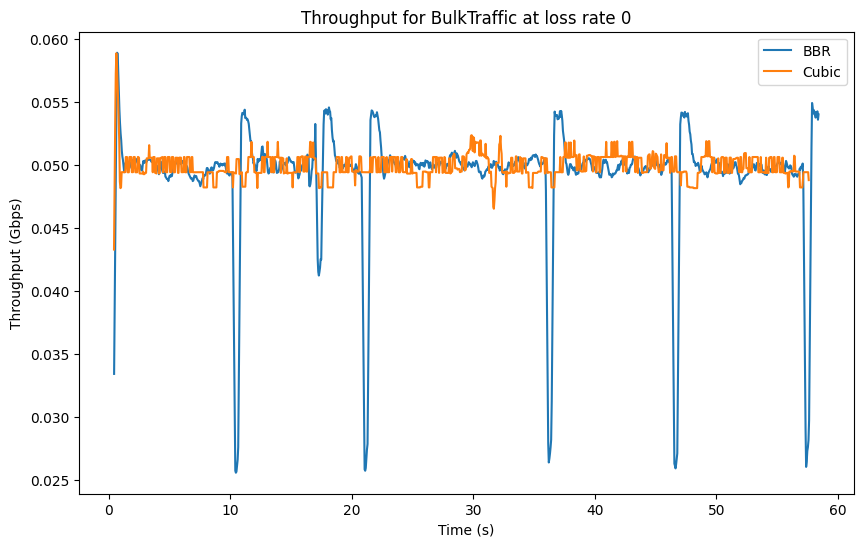

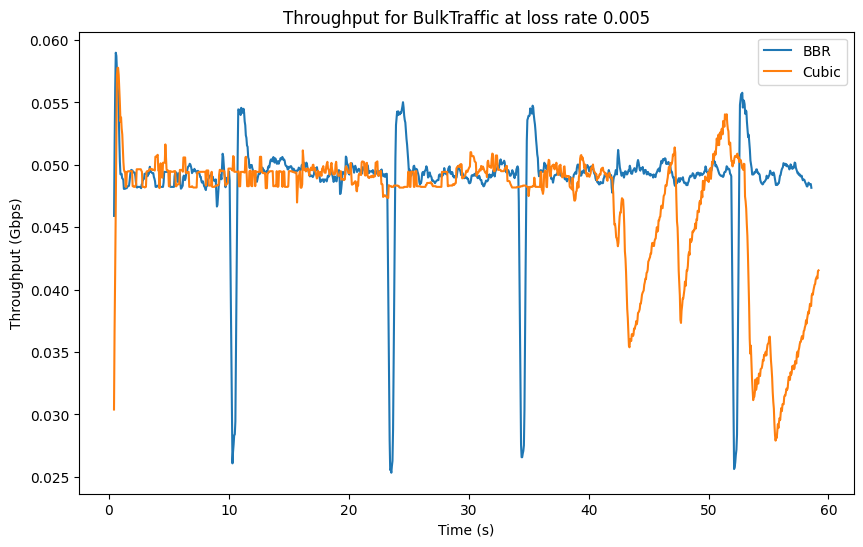

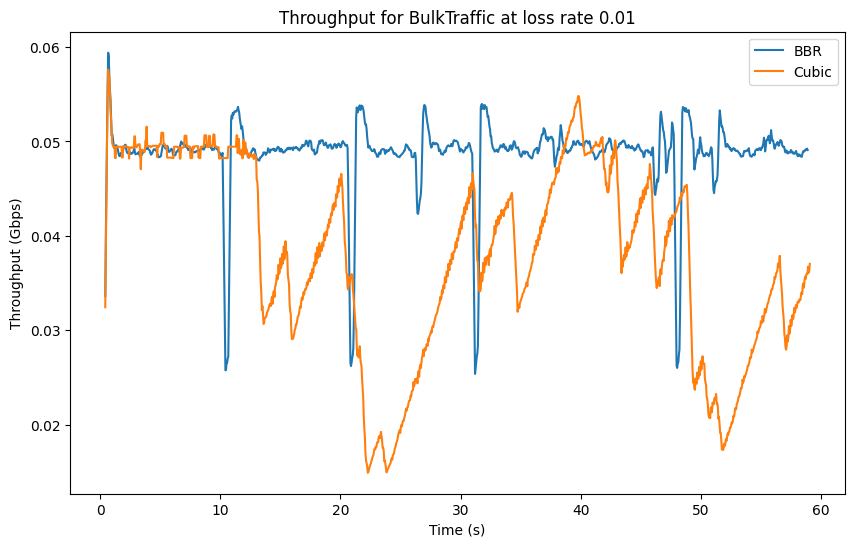

In [8]:
application_type = "BulkTraffic"
for loss_rate in [0, 0.005, 0.01]:
    graph_compare_throughput_of_two_algorithms_over_time(loss_rate, application_type, smoothen_data_rate=10)

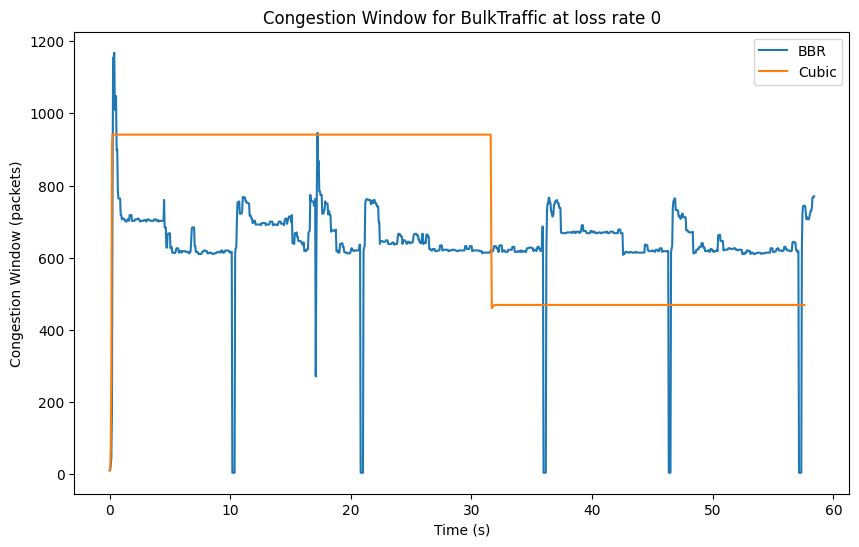

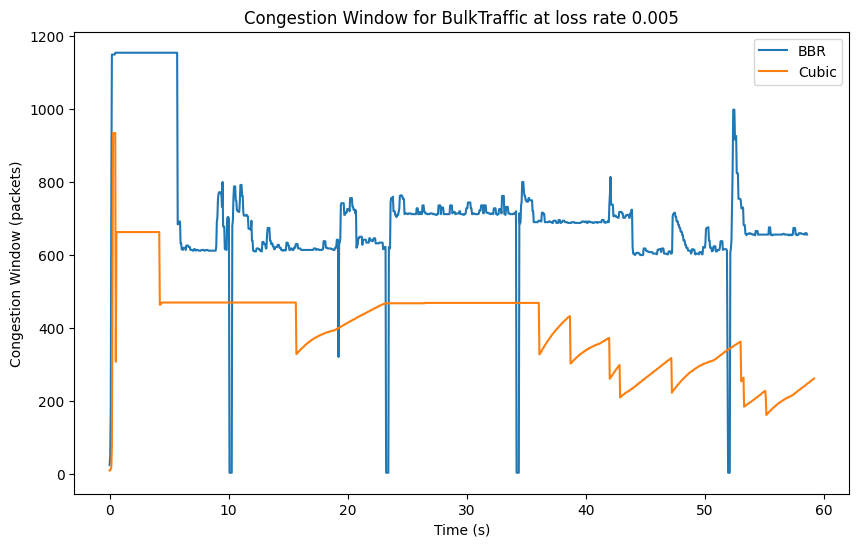

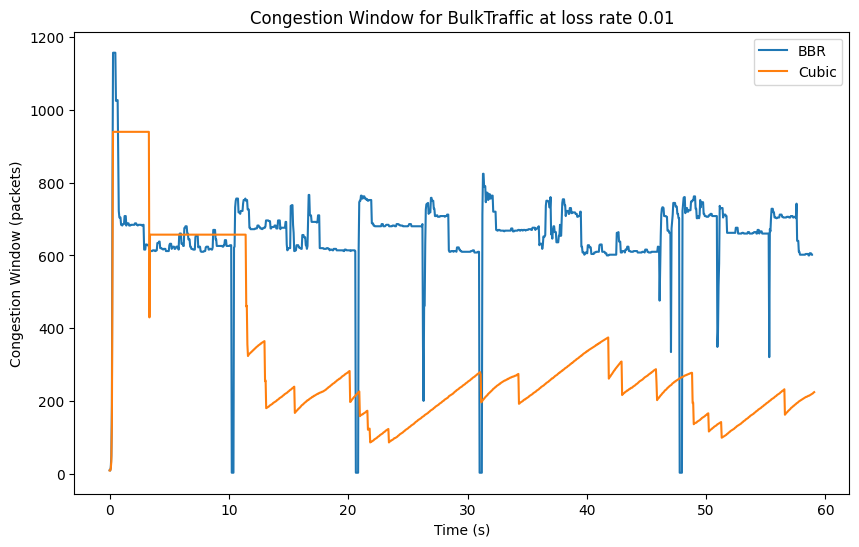

In [9]:
application_type = "BulkTraffic"
for loss_rate in [0, 0.005, 0.01]:
    graph_compare_congestion_window_of_two_algorithms_over_time(loss_rate, application_type)

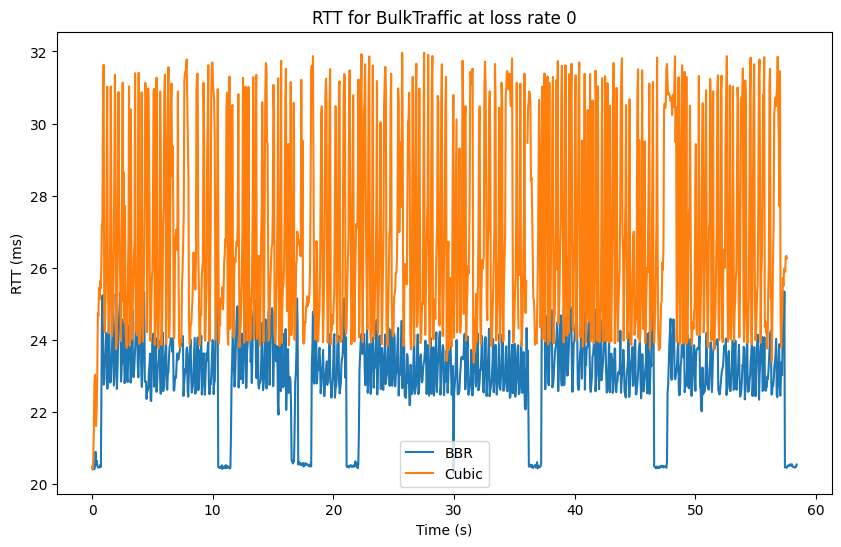

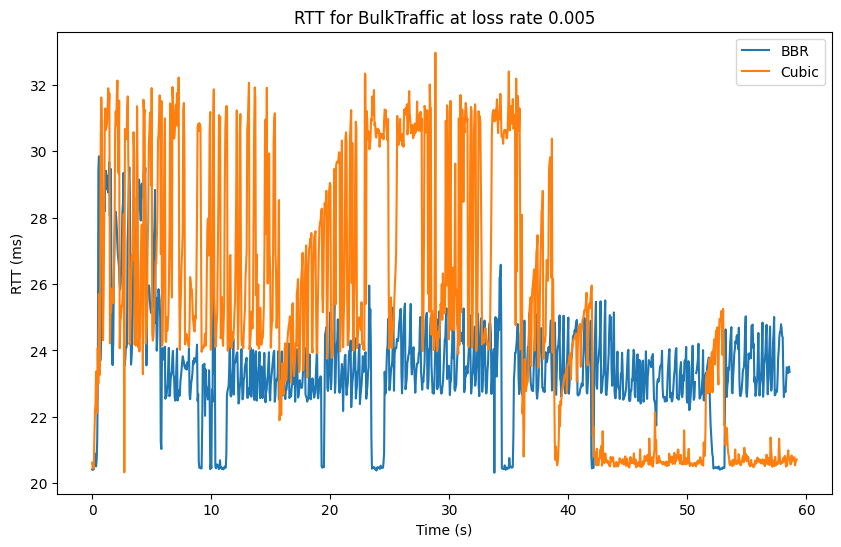

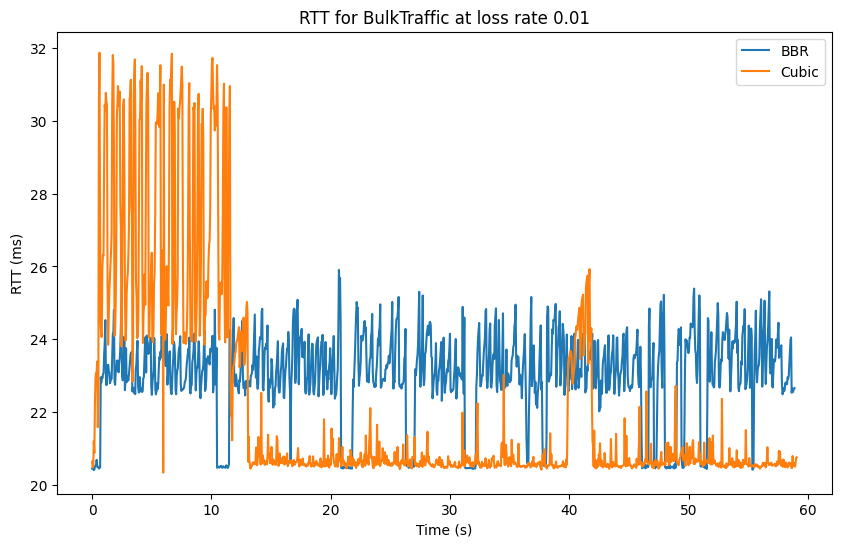

In [10]:
application_type = "BulkTraffic"
for loss_rate in [0, 0.005, 0.01]:
    graph_compare_rtt_of_two_algorithms_over_time(loss_rate, application_type)

# Below you can find comparison of BBR and Cubic for Website 
(eg. wgeting website with embeded PDF of size 10MB)

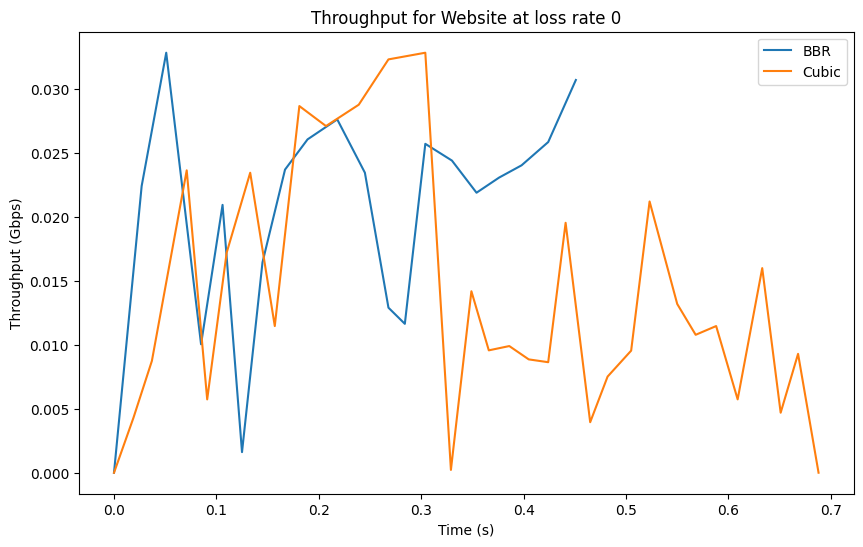

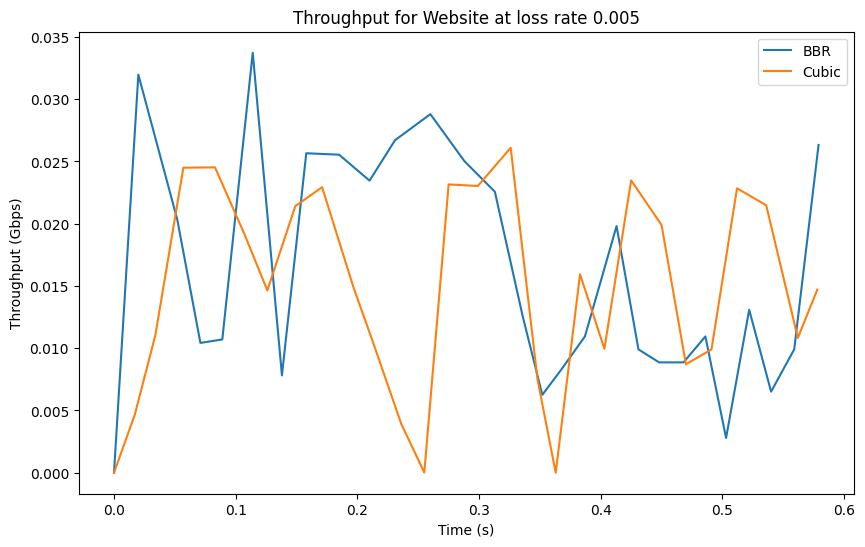

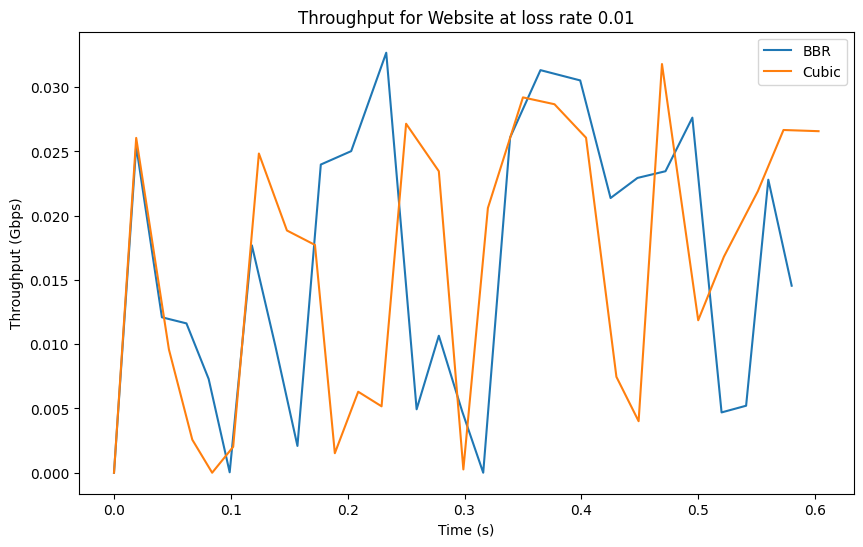

In [11]:
application_type = "Website"
for loss_rate in [0, 0.005, 0.01]:
    graph_compare_throughput_of_two_algorithms_over_time(loss_rate, application_type)

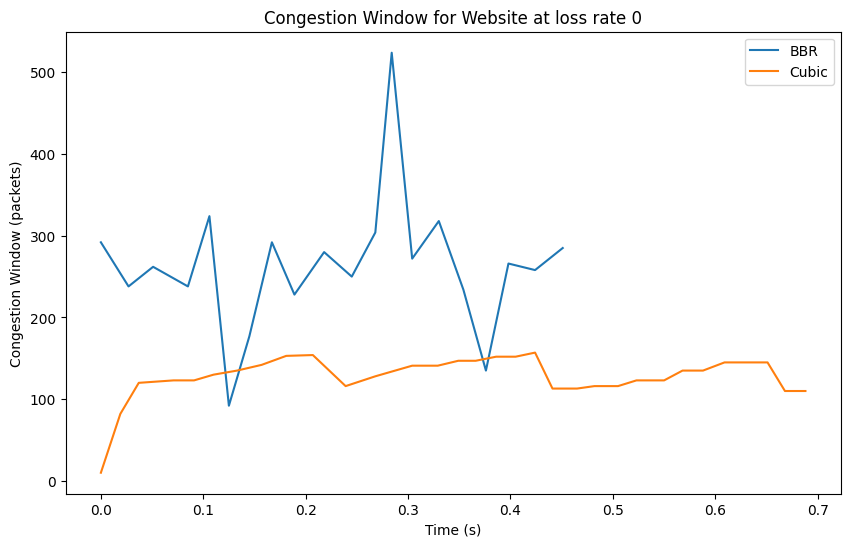

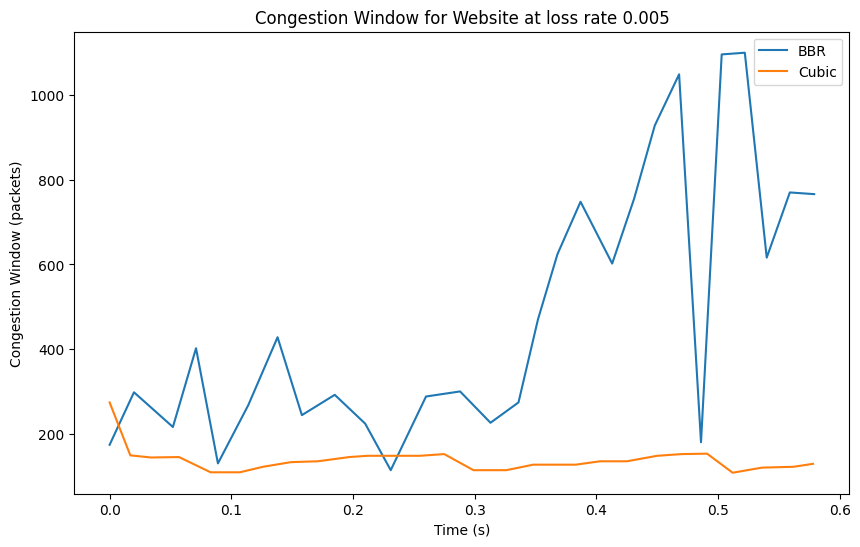

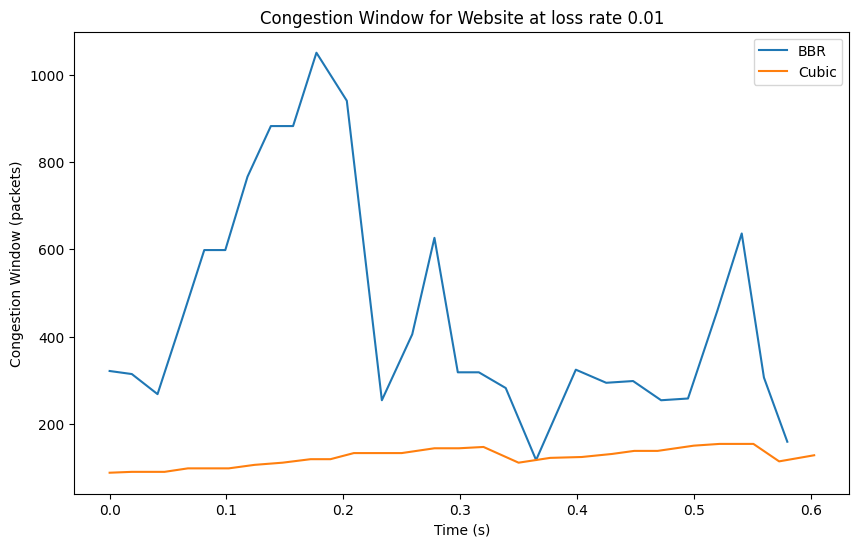

In [12]:
application_type = "Website"
for loss_rate in [0, 0.005, 0.01]:
    graph_compare_congestion_window_of_two_algorithms_over_time(loss_rate, application_type)

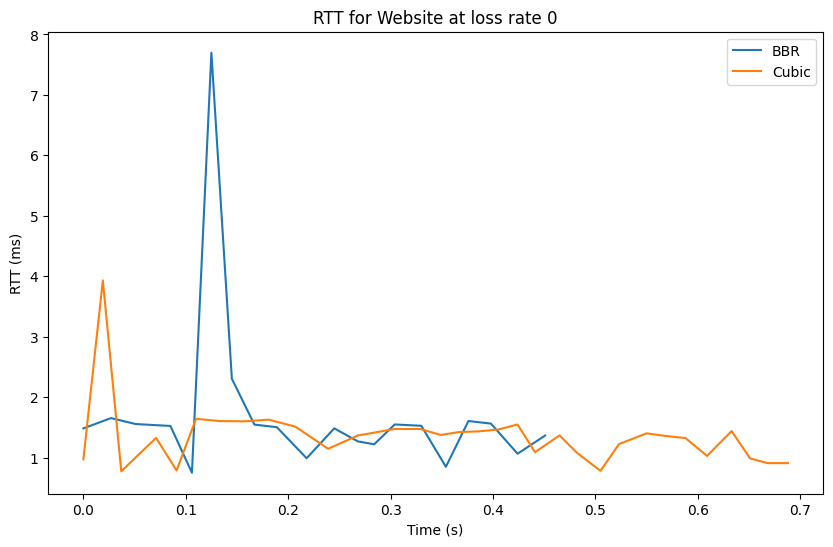

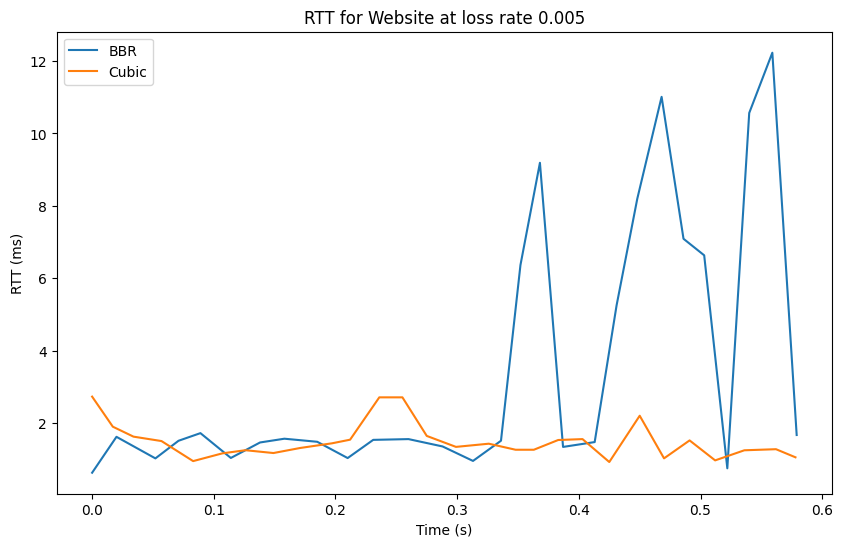

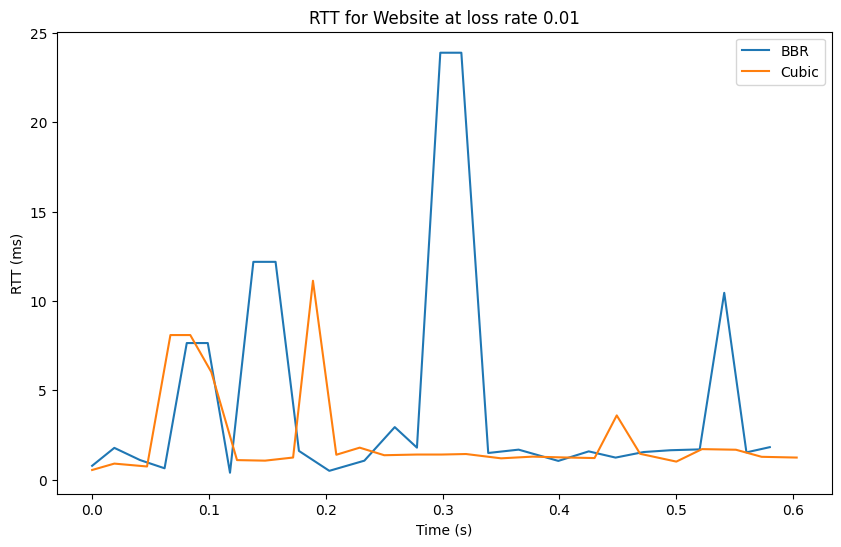

In [13]:
application_type = "Website"
for loss_rate in [0, 0.005, 0.01]:
    graph_compare_rtt_of_two_algorithms_over_time(loss_rate, application_type)